# Bigram Extraction

**Задача**: 
1. извлечь по определенным шаблонам биграммы из статей по физике;
2. проанализировать частотности биграмм.

In [1]:
import os
import re

import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pymorphy2 as pm2
import seaborn as sns

### 0. Data Loading

Загрузим датасет - корпус научных статей по физике:

In [2]:
data_directory = '../data/elibrary_physics_15k'
file_contents = []

for filename in os.scandir(data_directory):
    if filename.is_file():
        with open(filename, "r", encoding='utf-8') as f:
            text = f.read()
            file_contents.append(text)

KeyboardInterrupt: 

In [ ]:
raw_df = pd.DataFrame(file_contents, columns=['raw_text'])
raw_df

In [ ]:
articles_count = raw_df.shape[0]
print(f'Размер выборки: {articles_count}')

### 1. Data Preprocessing

#### 1.1 Filtering matching bigrams

Найдем в текстах статей биграммы следующих типов:
1. прилагательное + существительное *(им. падеж)*;
2. существительное *(им. падеж)* + существительное *(род. падеж)*.

In [ ]:
lemmatizer = pm2.MorphAnalyzer(lang='ru')

In [ ]:
def match_bigram(lemmatizer, word1, word2):
    """Tries to match bigram with any of the patterns."""
    word1_parse = lemmatizer.parse(word1)[0]
    word2_parse = lemmatizer.parse(word2)[0]

    word1_pos = word1_parse.tag.POS
    word2_pos = word2_parse.tag.POS
    if word2_pos != 'NOUN' or word1_pos not in {'NOUN', 'ADJF'}:
        return None

    word1_inflection = (word1_parse.tag.gender, word1_parse.tag.number, word1_parse.tag.case)
    word2_inflection = (word2_parse.tag.gender, word2_parse.tag.number, word2_parse.tag.case)

    # 'adj + noun' pattern
    if (
        word1_pos == 'ADJF' and word2_pos == 'NOUN' 
        and word1_inflection[1] == word2_inflection[1]
        and word1_inflection[2] == word2_inflection[2]
        and (
            word1_inflection[0] == word2_inflection[0]
            or word1_inflection[0] is None and word1_inflection[1] == 'plur'
        )
    ):
        word2_normal_form = word2_parse.normal_form
        word2_gender = word2_parse.normalized.tag.gender
        word2_number = word2_parse.normalized.tag.number

        inflection = {word2_number}
        if word2_number != 'plur':
            if word2_gender is None:
                return None
            inflection.add(word2_gender)
        word1_gender_match = word1_parse.normalized.inflect(inflection).word

        return word1_gender_match + ' ' + word2_normal_form, 'прил. + сущ.'

    # 'noun + noun' pattern
    if word1_pos == 'NOUN' and word2_pos == 'NOUN' and word2_inflection[2] == 'gent':
        word1_normal_form = word1_parse.normal_form

        return word1_normal_form + ' ' + word2_parse.word, 'сущ. + сущ.'

    return None

In [ ]:
print(match_bigram(lemmatizer, 'бревно', 'хорошо'))
print(match_bigram(lemmatizer, 'прелестными', 'девушками'))
print(match_bigram(lemmatizer, 'джентльменов', 'удачи'))

Зададим список стоп-слов:

In [ ]:
stop_words = stopwords.words('russian')

stop_words.extend(
    [
        # adjective-like pronouns
        'мой', 'твой', 'ваш', 'наш', 'свой', 'его', 'ее', 'их',
        'тот', 'этот', 'такой', 'таков', 'сей', 'который',
        'весь', 'всякий', 'сам', 'самый', 'каждый', 'любой', 'иной', 'другой',
        'какой', 'каков', 'чей', 'никакой', 'ничей',
        'какой-то', 'какой-либо', 'какой-нибудь', 'некоторый', 'некий',
        # participles
        'соответствующий', 'следующий', 'данный',
        # numerals
        'один',
        # insignificant words
        'друг',
    ]
)

stop_words = set(stop_words)

Зададим список стоп-биграмм:

In [ ]:
stop_bigrams = []

stop_bigrams.extend(
    [
        'крайняя мера', 'сегодняшний день', 'настоящее время', 'настоящая работа',
        'настоящая статья', 'точка зрения', 'первая очередь', 'последний год',
    ]
)

stop_bigrams = set(stop_bigrams)

Подходящие слова должны содержать только буквы и дефисы (последние не в начале/конце слова):

In [ ]:
def match_unigram(word):
    """Checks if a word is long enough and contains only letters and dashes."""
    if word.startswith('-') or word.endswith('-'):
        return False

    word_dashless = word.replace('-', '')
    return len(word_dashless) >= 3 and word_dashless.isalpha()

*Следующий шаг **не нужно выполнять**, если биграммы уже записаны в датафрейм.*

Сохраним о каждой подходящей биграмме следующую информацию:
- тип биграммы (прил. + сущ. | сущ. + сущ.);
- частота встречаемости (TF);
- подокументная частота (DF).

In [ ]:
bigram_stats = {}

for article in file_contents:
    # tokenization
    tokens = word_tokenize(article, language='russian')

    # case normalization
    uncased_tokens = []
    for token in tokens:
        if token.isalpha():
            token = token.lower()
        uncased_tokens.append(token)

    # short and/or non-letter words removal
    standardized_tokens = []
    for token in uncased_tokens:
        if match_unigram(token):
            standardized_tokens.append(token)

    unique_bigrams = set()
    for i in range(len(standardized_tokens) - 1):
        token1, token2 = standardized_tokens[i], standardized_tokens[i + 1]

        # stop-words removal
        token1_normal = lemmatizer.parse(token1)[0].normal_form
        token2_normal = lemmatizer.parse(token2)[0].normal_form
        if token1_normal in stop_words or token2_normal in stop_words:
            continue

        # bigram extraction
        bigram_info = match_bigram(lemmatizer, token1, token2)
        if bigram_info is not None:
            bigram, bigram_pattern = bigram_info

            # stop-bigrams removal
            if bigram in stop_bigrams:
                continue

            unique_bigrams.add(bigram)

            if bigram not in bigram_stats:
                bigram_stats[bigram] = {
                    'Pattern': bigram_pattern,
                    'TF': 1,
                    'DF': 0,
                }
            else:
                bigram_stats[bigram]['TF'] += 1

    # DF statistics update
    for bigram in unique_bigrams:
        bigram_stats[bigram]['DF'] += 1

In [ ]:
print(f'Количество подходящих биграмм: {len(bigram_stats)}')

Часть информации была утеряна, т.к. pymorphy2 не всегда может морфологически корректно разобрать слово.

Например, выведем все слова в подходящих паттернах биграмм, у которых анализатор не смог определить падеж:

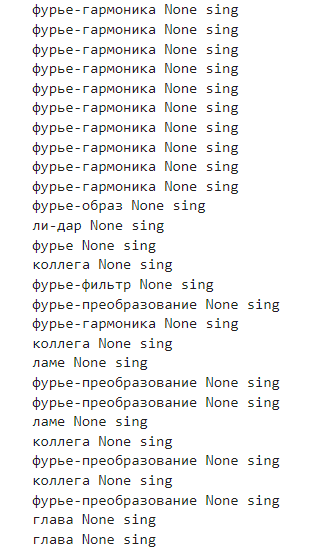

#### 1.2 Saving extracted data

Запишем собранную информацию о биграммах, **имеющих DF >= 10**, в датафрейм:

In [ ]:
bigram_df = pd.DataFrame(bigram_stats).T.reset_index()
bigram_df.rename(
    columns={
        'index': 'normal_form',
        'Pattern': 'pos_pattern',
        'TF': 'tf',
        'DF': 'df',
    },
    inplace=True,
)
bigram_df = bigram_df[bigram_df['df'] >= 10].reset_index(drop=True)

bigram_df

Сохраним информацию о биграммах в .csv файл, чтобы не пересчитывать их каждый раз:

In [ ]:
bigram_df.to_csv('../data/data_frames/bigram_stats.csv')

#### 1.3 Gathering unigrams frequency statistics

Для подсчета метрики **MI3** потребуется дополнительная информация:
- частотность униграмм;
- размер словаря.

Посчитаем их.

In [ ]:
unigram_stats = {}

for article in file_contents:
    # tokenization
    tokens = word_tokenize(article, language='russian')

    # case normalization
    uncased_tokens = []
    for token in tokens:
        if token.isalpha():
            token = token.lower()
        uncased_tokens.append(token)

    # short and/or non-letter words removal
    standardized_tokens = []
    for token in uncased_tokens:
        if match_unigram(token):
            standardized_tokens.append(token)

    unique_tokens = set()
    for token in standardized_tokens:
        # normalization
        normal_form = lemmatizer.parse(token)[0].normal_form
        
        # stop-words removal
        if normal_form in stop_words:
            continue
        
        unique_tokens.add(normal_form)

        # statistics update
        if normal_form not in unigram_stats:
            unigram_stats[normal_form] = {
                'TF': 1,
                'DF': 0,
            }
        else:
            unigram_stats[normal_form]['TF'] += 1

    for token in unique_tokens:
        unigram_stats[token]['DF'] += 1

In [ ]:
unigram_df = pd.DataFrame(unigram_stats).T.reset_index()
unigram_df.rename(
    columns={
        'index': 'normal_form',
        'TF': 'tf',
        'DF': 'df',
    },
    inplace=True,
)
unigram_df = unigram_df[unigram_df['df'] >= 10].reset_index(drop=True)

unigram_df

In [ ]:
unigram_df.to_csv('../data/data_frames/unigram_stats.csv')

### 2. Data Analysis

*Всегда теперь будем **только подгружать** сгенерированные датафреймы.*

In [ ]:
bigram_df = pd.read_csv('../data/data_frames/bigram_stats.csv', index_col=0)

In [ ]:
unigram_df = pd.read_csv('../data/data_frames/unigram_stats.csv', index_col=0)

In [ ]:
corpus_size = len(unigram_df)
print(f'Размер корпуса: {corpus_size}')

Увеличим кол-во отображаемых строк в датафреймах:

In [ ]:
pd.set_option('display.max_rows', 100)

Будем рассматривать 3 отдельных топа биграмм *(top50 and bottom50)*:
1. TF;
2. DF;
3. TF-IDF (natural: TF = count).

#### 2.1 TF

Выведем *top-100* (слева) and *bottom-100* (справа) биграмм, отранжированных по **tf**:

In [ ]:
top_tf_df = bigram_df.sort_values(by=['tf'], ignore_index=True, ascending=False)
bottom_tf_df = bigram_df.sort_values(by=['tf'], ignore_index=True)

top_tf_df['<---------->'] = '|'
pd.concat([top_tf_df.reset_index(drop=True), bottom_tf_df.reset_index(drop=True)], axis=1).head(100)

#### 2.2 DF

Выведем *top-100* (слева) and *bottom-100* (справа) биграмм, отранжированных по **df**:

In [ ]:
top_df_df = bigram_df.sort_values(by=['df'], ignore_index=True, ascending=False)
bottom_df_df = bigram_df.sort_values(by=['df'], ignore_index=True)

top_df_df['<---------->'] = '|'
pd.concat([top_df_df.reset_index(drop=True), bottom_df_df.reset_index(drop=True)], axis=1).head(100)

#### 2.3 TF-IDF (natural TF)

Посчитаем TF-IDF (TF = count) для биграмм:

In [ ]:
idf = bigram_df['df'].apply(lambda x: np.log10(articles_count / x))
tf_idf = bigram_df['tf'] * idf

bigram_tf_idf_df = bigram_df.copy()
bigram_tf_idf_df['tf_idf_natural'] = tf_idf
bigram_tf_idf_df.sort_values(by=['tf_idf_natural'], ignore_index=True, inplace=True, ascending=False)
bigram_tf_idf_df = bigram_tf_idf_df.round(decimals=2)

bigram_tf_idf_df

Выведем *top-100* (слева) and *bottom-100* (справа) биграмм, отранжированных по **tf-idf**:

In [ ]:
top_tf_idf_df = bigram_tf_idf_df.copy()
bottom_tf_idf_df = bigram_tf_idf_df.sort_values(by=['tf_idf_natural'], ignore_index=True)

top_tf_idf_df['<---------->'] = '|'
pd.concat([top_tf_idf_df.reset_index(drop=True), bottom_tf_idf_df.reset_index(drop=True)], axis=1).head(100)

#### 2.4 MI3

Некоторые биграммы некорректно преобразуются при пословной нормализации. Зададим для них коррекцию:

In [ ]:
bigram_corrections = {
    ('быть', 'дело'): ('суть', 'дело'),
    ('неодимовыя', 'лазер'): ('неодимовый', 'лазер'),
    ('великое', 'объединение'): ('великий', 'объединение'),
    ('эрбиева', 'лазер'): ('эрбиевой', 'лазер'),
    ('воробей', 'гора'): ('воробьёв', 'гора'),
    ('должное', 'внимание'): ('должный', 'внимание'),
    ('железо-иттриева', 'гранат'): ('железо-иттриевой', 'гранат'),
    ('атомносил', 'микроскопия'): ('атомносилов', 'микроскопия'),
}

Посчитаем взаимную информацию MI3 для биграмм:

In [ ]:
mi3_scores = []
for _, row in bigram_tf_idf_df.iterrows():
    bigram = row['normal_form']
    bigram_tf = row['tf']

    unigrams = tuple([lemmatizer.parse(x)[0].normal_form for x in bigram.split()])
    if unigrams in bigram_corrections:
        unigrams = bigram_corrections[unigrams]

    unigram_1_tf = unigram_df[unigram_df['normal_form'] == unigrams[0]]['tf'].values[0]
    unigram_2_tf = unigram_df[unigram_df['normal_form'] == unigrams[1]]['tf'].values[0]

    mi3_scores.append(np.log2((corpus_size * bigram_tf ** 3) / (unigram_1_tf * unigram_2_tf)))

mi3_scores = np.array(mi3_scores)

bigram_mi3_df = bigram_tf_idf_df.copy()
bigram_mi3_df['mi3'] = mi3_scores

bigram_mi3_df.sort_values(by=['mi3'], ignore_index=True, inplace=True, ascending=False)
bigram_mi3_df = bigram_mi3_df.round(decimals=2)

bigram_mi3_df

Сохраним частотную статистику по биграммам:

In [ ]:
bigram_mi3_df.to_csv('../data/data_frames/bigram_tfidf_mi3_scores.csv')

Выведем *top-100* (слева) and *bottom-100* (справа) биграмм, отранжированных по **mi3**:

In [ ]:
top_mi3_df = bigram_mi3_df.copy()
bottom_mi3_df = bigram_mi3_df.sort_values(by=['mi3'], ignore_index=True)

top_mi3_df['<---------->'] = '|'
pd.concat([top_mi3_df.reset_index(drop=True), bottom_mi3_df.reset_index(drop=True)], axis=1).head(100)

#### 2.5 Visual representation

Отразим на графиках частотные характеристики корпуса:

In [ ]:
tf_plot = top_tf_df.head(100).plot(x='normal_form', y='tf', kind='bar', title='Top-100 TF-frequent Bigrams', figsize=(20, 5))

In [ ]:
df_plot = top_df_df.head(100).plot(x='normal_form', y='df', kind='bar', title='Top-100 DF-frequent Bigrams', figsize=(20, 5), color='red')

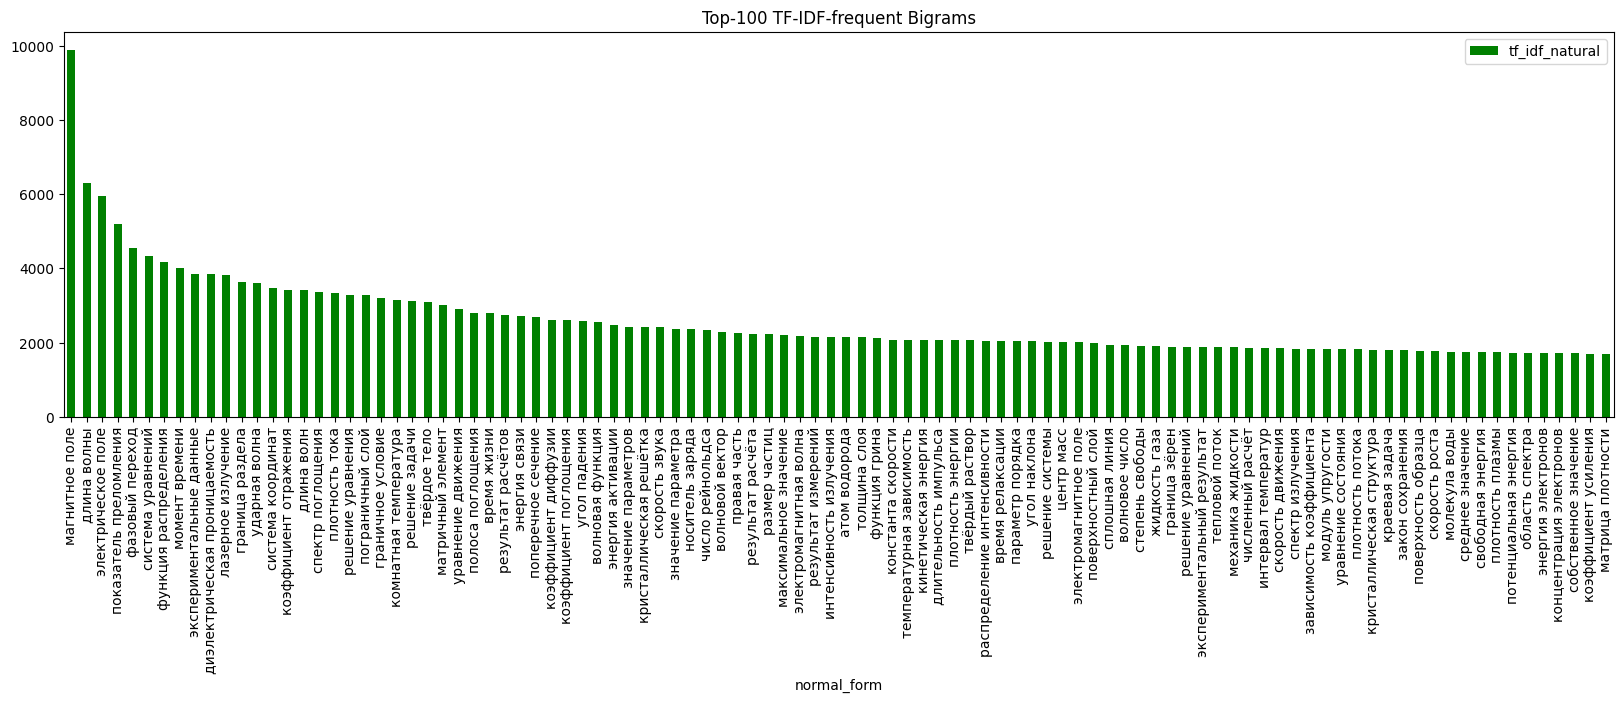

In [131]:
tf_idf_plot = bigram_tf_idf_df.head(50).plot(
    x='normal_form', y='tf_idf_natural', kind='bar', title='Top-50 TF-IDF-frequent Bigrams', figsize=(20, 5), color='green'
)

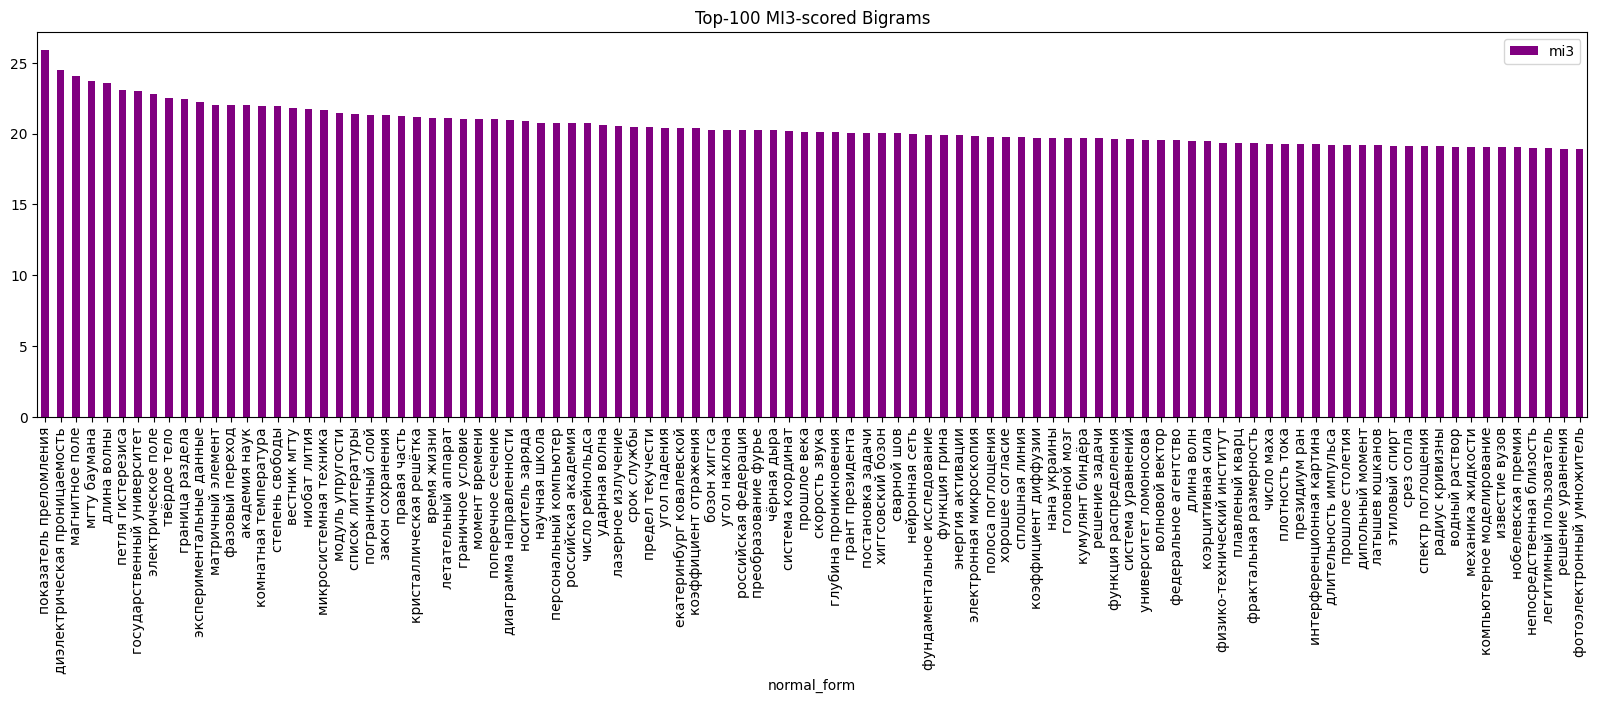

In [132]:
mi3_plot = bigram_mi3_df.head(100).plot(
    x='normal_form', y='mi3', kind='bar', title='Top-100 MI3-scored Bigrams', figsize=(20, 5), color='purple'
)

### 3. Conclusion

Биграммы на порядок лучше униграмм отражают тематику области. Паттерны *"прил. + сущ."* и *"сущ. + сущ."* довольно часто соответствуют сочетаниям слов, похожих на или крутящихся около терминов.

#### 3.1 Notes

- анализатор не может *определить род* в биграммах, содержащих **англоязычные имена** или **неизменяемые слова**: "фурье-гармоника" -> None (фурье все портит);
- в паттерне *сущ. + сущ.* **второе существительное не приводилось к нормальной форме** перед добавлением в словарь. Сделал так, потому что порой словосочетание теряет свою привычную форму после нормализации: "система уравнений" -> "система уравнения", т.е. не всегда можно безболезненно избавиться от множественного числа. Однако из-за этого некоторые одинаковые биграммы трактовались как разные ("длина волн" и "длина волны", **причем обе в топе по tf-idf**, что плохо). *Что нам важнее*: адекватность статистики по частотам, или сохранность форм биграмм?
- при подсчете размера корпуса учитывал только **униграммы, удовлетворяющие тем же ограничениям, что и биграммы**:
    - кол-во символов >= 3;
    - нет цифр в слове;
    - df >= 10.
    
  Если учитывать вообще все, то это **сильно завысит значение метрики MI3** (размер корпуса будет огромный). Но правильно ли ограничение на df? Так, после этих ограничений, кол-во уникальных словоформ сократилось со 144к до всего лишь 9к, меня смущает это немного;
- (**NEW**) На увеличенном корпусе (и после чистки стоп-биграмм) в топ-100 MI3 **встречается много именованных сущностей** ("мгту баумана", "петля гистерезиса", "вестник МГТУ", и т.д);
- (**NEW**) На дне топа MI3 достаточно прилично биграмм с отрицательными оценками MI3. Кажется, в таких случаях для лучших результатов используют модификацию PPMI, т.е. обнуляют отрицательные значения. Но неуверен, нужно ли это вообще в нашей задаче;
- (**NEW**) В топ-100 tf-idf большая часть словосочетаний - широко распространенные физические термины. Но "трендовых" терминов (т.е. то, что мы хотим найти) нет - оно и понятно. 
- (**NEW**) В увеличенном корпусе встречались тексты полностью на английском, но **ни в одном топе нет английских биграмм** (потому что русский анализатор не умеет тегировать им часть речи -> не проходят биграммные паттерны);
- (**NEW**) Словарь коррекций сам по себе тоже *не особо корректный* :) Я подгонял его под словарь униграмм, который составлялся неумелым pymorphy -> не идеальная коррекция, но благо случаев ошибочных пока немного;
- (**NEW**) В добавленном корпусе 1 архив был в формате .hdr -> я пытался и инструментами питона открыть его, и онлайн декодировщиками расшифровать/перевести в другой формат. Все бестолку, *везде ошибка чтения файла*. В итоге я не учитывал этот архив. Получилось в корпусе 15к статей (могло быть 16к).

#### 3.2 Improvements

- все **"проблемные" биграммы обработать отдельно**, в них может содержаться релевантная тематическая информация;
- **TO-DO:**
    1. ;
    2. ;
    3. .